# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

## Откройте файл с данными и изучите общую информацию

In [1]:
#Импортируем библиотеки и выведем первые пять строк датафрейма
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
pd.set_option('display.max_columns', None)
sns.set()
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [3]:
#Выводим основную информацию о датафрейме
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Описание данных:
- airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
- balcony — число балконов
- ceiling_height — высота потолков (м)
- cityCenters_nearest — расстояние до центра города (м)
- days_exposition — сколько дней было размещено объявление (от публикации до снятия)
- first_day_exposition — дата публикации
- floor — этаж
- floors_total — всего этажей в доме
- is_apartment — апартаменты (булев тип)
- kitchen_area — площадь кухни в квадратных метрах (м²)
- last_price — цена на момент снятия с публикации
- living_area — жилая площадь в квадратных метрах (м²)
- locality_name — название населённого пункта
- open_plan — свободная планировка (булев тип)
- parks_around3000 — число парков в радиусе 3 км
- parks_nearest — расстояние до ближайшего парка (м)
- ponds_around3000 — число водоёмов в радиусе 3 км
- ponds_nearest — расстояние до ближайшего водоёма (м)
- rooms — число комнат
- studio — квартира-студия (булев тип)
- total_area — общая площадь квартиры в квадратных метрах (м²)
- total_images — число фотографий квартиры в объявлении

In [4]:
len(data)

23699

Итого у нас 23699 строк данных. Исходя из информации о датафрейме уже можно сказать, что присутствуют пропуски и тип данных в некоторых столбцах некорректный.

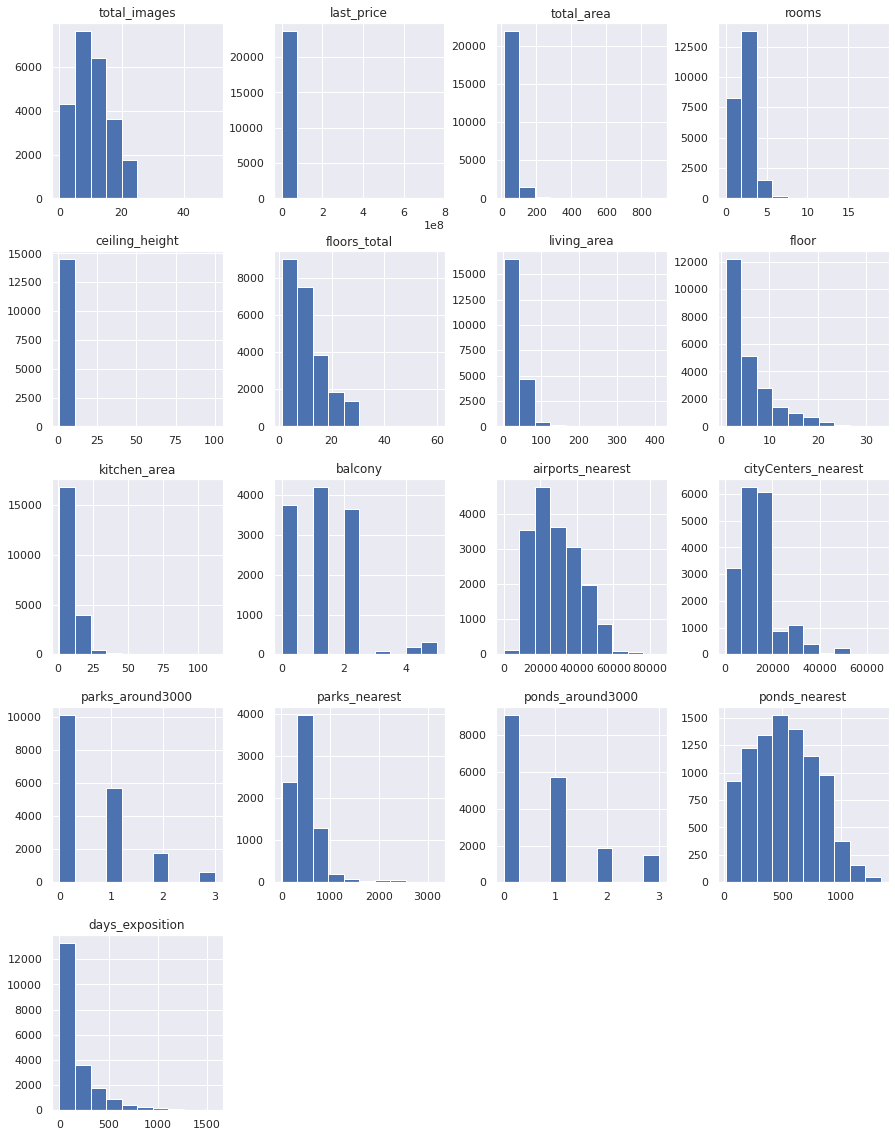

In [5]:
#Построим гистограммы
data.hist(figsize=(15, 20));

Из построенных гистограмм видно большое кличество пропущенных значений,а также в некоторых столбцах (ceiling_height) видны аномалии. Данные нуждаются в предобработке перед анализом.

## Выполните предобработку данных.

In [6]:
#Посчитаем количество пропущенных значений для каждого столбца
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [7]:
#Посчитаем число явных дубликатов
data.duplicated().sum()

0

In [8]:
#Приведем дату публикации объявления к корректному виду
data['first_day_exposition'] = pd.to_datetime(
    data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

In [9]:
#Посмотрим на уникальные значения в столбце ceiling_height
data['ceiling_height'].unique()

array([  2.7 ,    nan,   3.03,   2.5 ,   2.67,   2.56,   3.05,   2.75,
         2.6 ,   2.9 ,   2.8 ,   2.55,   3.  ,   2.65,   3.2 ,   2.61,
         3.25,   3.45,   2.77,   2.85,   2.64,   2.57,   4.15,   3.5 ,
         3.3 ,   2.71,   4.  ,   2.47,   2.73,   2.84,   3.1 ,   2.34,
         3.4 ,   3.06,   2.72,   2.54,   2.51,   2.78,   2.76,  25.  ,
         2.58,   3.7 ,   2.52,   5.2 ,   2.87,   2.66,   2.59,   2.  ,
         2.45,   3.6 ,   2.92,   3.11,   3.13,   3.8 ,   3.15,   3.55,
         3.16,   3.62,   3.12,   2.53,   2.74,   2.96,   2.46,   5.3 ,
         5.  ,   2.79,   2.95,   4.06,   2.94,   3.82,   3.54,   3.53,
         2.83,   4.7 ,   2.4 ,   3.38,   3.01,   5.6 ,   3.65,   3.9 ,
         3.18,   3.35,   2.3 ,   3.57,   2.48,   2.62,   2.82,   3.98,
         2.63,   3.83,   3.52,   3.95,   3.75,   2.88,   3.67,   3.87,
         3.66,   3.85,   3.86,   4.19,   3.24,   4.8 ,   4.5 ,   4.2 ,
         3.36,  32.  ,   3.08,   3.68,   3.07,   3.37,   3.09,   8.  ,
      

In [10]:
#С помощью метода sort_values посмотрим аномальные значения по убыванию
data['ceiling_height'].sort_values(ascending=False).head(25)

22869    100.0
22336     32.0
3148      32.0
21377     27.5
20478     27.0
5246      27.0
5807      27.0
10773     27.0
17857     27.0
22938     27.0
21824     27.0
4876      27.0
5669      26.0
18545     25.0
11285     25.0
355       25.0
6246      25.0
14382     25.0
4643      25.0
9379      25.0
5076      24.0
20507     22.6
17496     20.0
15061     14.0
22309     10.3
Name: ceiling_height, dtype: float64

Видно, что в данном столбце есть ошибки (потолки > 20 м), а в столбце 9195 пропуск. Скорректируем данные и заполним пустые ячейки медианным значением для дальнейшего анализа.

In [11]:
#Скорректируем ячейки с ошибочными данными
data.loc[data['ceiling_height'] >= 20.0, 'ceiling_height'] = data['ceiling_height'] * 0.1
#Заполняем пропуски медианым значением
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())
#Проверяем
data['ceiling_height'].isnull().sum()

0

In [12]:
#В столбце также 86 пропусков, удалим строки из датафрейма
data.dropna(subset=['floors_total'], inplace=True)
data.reset_index(drop=True)
#Заменим в столбце этажности значения на целые
data['floors_total'] = data['floors_total'].astype('int')
#Проверяем
data['floors_total'].isnull().sum()

0

В столбце living_area 1903 пропуска, при этом мы точно знаем, что в датафрейме данные по жилой недвижимости и у нас есть данные общей площади, соответственно, данные значения были пропущены и их необходимо заполнить медианным значением.

In [13]:
#Создадим переменную исключающие пропуски
living_area_no_zero = data['living_area'].dropna()
#Считаем медиану
living_area_no_zero = living_area_no_zero.median()
#Заменяем нулевые значения на медиану
data.loc[data['living_area'].isnull(), 'living_area'] = living_area_no_zero
#Проверяем
data['living_area'].describe()

count    23613.000000
mean        34.109357
std         21.181099
min          2.000000
25%         19.000000
50%         30.000000
75%         41.100000
max        409.700000
Name: living_area, dtype: float64

Столбец is_apartment должен принимать значение True и False, при этом в столбце 20924 пропущенных значений. Апартаменты это непопулярный тип недвижимости, так что мы вполне можем заменить значения на False. Также переменная имеет тип данных "object", необходимо заменить его на bool.

In [14]:
data['is_apartment'] = data['is_apartment'].fillna(value=False)
data['is_apartment'] = data['is_apartment'].astype(bool)
#Проверяем
data['floors_total'].isnull().sum()

0

В столбце kitchen_area 2278 пропущенных значений. Обработаем данные аналогично столбцу living_area.

In [15]:
#Создадим переменную исключающие пропуски
kitchen_area_no_zero = data['kitchen_area'].dropna()
#Считаем медиану
kitchen_area_no_zero = kitchen_area_no_zero.median()
#Заменяем нулевые значения на медиану
data.loc[data['kitchen_area'].isnull(), 'kitchen_area'] = kitchen_area_no_zero
#Проверяем
data['kitchen_area'].describe()

count    23613.000000
mean        10.425794
std          5.634758
min          1.300000
25%          7.300000
50%          9.100000
75%         11.420000
max        112.000000
Name: kitchen_area, dtype: float64

В столбце balcony 11519 пропущенных значений. Мы вполне можем допустить, что в квартирах с пропущенным значением нет балкона. Заменим пропуски на ноль.

In [16]:
data['balcony'] = data['balcony'].fillna(0)
#Меняем тип данных на целые значения
data['balcony'] = data['balcony'].astype('int')
#Проверяем
data['floors_total'].isnull().sum()

0

В столбце locality_name (название населённого пункта) пропущено 49 значений, от них можно избавится, т.к. это не сильно повлияет на нашу выборку. Если мы вызовем уникальные значения данного столбца (data['locality_name'].unique()), то увидим что в нем присутствуют неявные дубликаты. 

In [17]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [18]:
#Заменяем в значениях букву ё на е и уберем лишнюю информацию в названиях
data['locality_name'] = (
    data['locality_name']
    .str.replace('ё', 'е')
    .replace(['поселок ','при железнодорожной станции ', 'платформа ', 'садоводческое некоммерческое товарищество ',
             'садовое товарищество ', 'станции ', 'село ', 'пансионат ', 'городского типа ',
             'деревня ', 'городской поселок '], '', regex=True)
) 
#Удалим 49 строк с пропущенным населенным пунктом
data.dropna(subset=['locality_name'], inplace=True)
data.reset_index(drop=True)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07,3,2.70,16,51.0,8,False,False,False,25.00,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04,1,2.65,11,18.6,1,False,False,False,11.00,2,Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20,2,2.65,5,34.3,4,False,False,False,8.30,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24,3,2.65,14,30.0,9,False,False,False,9.10,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19,2,3.03,14,32.0,13,False,False,False,41.00,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23560,9,9700000.0,133.81,2017-03-21,3,3.70,5,73.3,3,False,False,False,13.83,0,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN
23561,14,3100000.0,59.00,2018-01-15,3,2.65,5,38.0,4,False,False,False,8.50,0,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23562,18,2500000.0,56.70,2018-02-11,2,2.65,3,29.7,1,False,False,False,9.10,0,Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23563,13,11475000.0,76.75,2017-03-28,2,3.00,17,30.0,12,False,False,False,23.30,2,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0


В столбцах airports_nearest, cityCenters_nearest,parks_around3000, parks_nearest, ponds_around3000, ponds_nearest очень много пропусков. Это может указывать как на то, что рядом с недвижимостью нет аэропорта/центра города/парка/пруда, так и объяснятся некорректной выгрузкой данных или отсутствием информации об этом в геосервисах. Оставим все так, как есть. Значения в parks_around3000 и ponds_around3000 можно заменить нулями (т.к. скорее всего их нет в радиусе 3000м). Приведем названия столбцов к нормальному виду.

In [19]:
#Переименуем наши столбцы
data = data.rename(columns={'cityCenters_nearest': 'city_centers_nearest', 
                            'parks_around3000': 'parks_around_3000', 
                            'ponds_around3000': 'ponds_around_3000'
                           }
                  )
#Заполним пропуски нулями
data['parks_around_3000'] = data['parks_around_3000'].fillna(0)
data['ponds_around_3000'] = data['ponds_around_3000'].fillna(0)

В столбце days_exposition 3181 пропуск. Пропуски, вероятно, указывают на то, что недвижимость еще не продана или пользователь снял объявление и продал квартиру на другой площадке. Оставим как есть, т.к. у нас нет никаких данных о причинах данных пропусков, а заполнение пропусков средним медианным значением было бы некорректно, т.к. у нас нет достоверных данных о продаже  недвижимости, что исказило бы результаты работы. Пока посмотрим на оставшиеся пропуски в нашем датафрейме.

In [20]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5524
city_centers_nearest     5501
parks_around_3000           0
parks_nearest           15535
ponds_around_3000           0
ponds_nearest           14529
days_exposition          3171
dtype: int64

Нам удалось существенно уменьшить число пропущенных значений и привести датафрейм к лучшему виду. Теперь с этими данными можно работать.

## Добавьте в таблицу новые столбцы.

In [21]:
# Цена одного квадратного метра
data['sq_m_price'] = data['last_price'] / data['total_area']
data['sq_m_price'] = data['sq_m_price'].round(2)
# День недели публикации объявления
data['date_issued'] = data['first_day_exposition'].dt.weekday 
# Месяц публикации объявления
data['month_issued'] = data['first_day_exposition'].dt.month
# Год публикации объявления
data['year_issued'] = data['first_day_exposition'].dt.year
# Тип этажа квартиры (значения — «первый», «последний», «другой»)
def floor_defined(row):
    if row['floor'] == 1:
        return 'первый'
    if row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'
data['category_by_floor'] = data.apply(floor_defined, axis=1)
# Расстояние до центра города в километрах 
data['city_center_distance'] = data['city_centers_nearest'] / 1000
data['city_center_distance'] = data['city_center_distance'].round(0)
# Выводим первые пять строк таблицы на экран и проверяем результат
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,sq_m_price,date_issued,month_issued,year_issued,category_by_floor,city_center_distance
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,False,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120370.37,3,3,2019,другой,16.0
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.6,1,False,False,False,11.0,2,Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82920.79,1,12,2018,первый,19.0
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.3,4,False,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785.71,3,8,2015,другой,14.0
3,0,64900000.0,159.0,2015-07-24,3,2.65,14,30.0,9,False,False,False,9.1,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,408176.10,4,7,2015,другой,7.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000.00,1,6,2018,другой,8.0


### Проведите исследовательский анализ данных.

До начала исследования влияния цены на объекты недвижимости необходимо описать наши основные параметры:
  - общая площадь;
  - жилая площадь;
  - площадь кухни;
  - цена объекта;
  - количество комнат;
  - высота потолков;
  - тип этажа квартиры («первый», «последний», «другой»);
  - общее количество этажей в доме;
  - расстояние до центра города в метрах;
  - расстояние до ближайшего парка. 

Также перед нами стоит задача научиться определять рыночную стоимость объектов недвижимости. Соответственно, нам необходимо изучить зависмость цены объекта от следующих параметров:
  - общая площадь;
  - жилая площадь;
  - площадь кухни;
  - количество комнат;
  - тип этажа, на котором расположена квартира (первый, последний, другой);
  - дата размещения (день недели, месяц, год).

### Общая площадь. 

In [22]:
data['total_area'].describe()

count    23565.000000
mean        60.322824
std         35.657060
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64

Медианная площадь квартиры чуть больше 60 кв.м, минимальное значение 12 кв.м, максимальное - 900 кв.м. Визуализируем данные на гистограмме, используя инструменты библиотеки matplotlib.

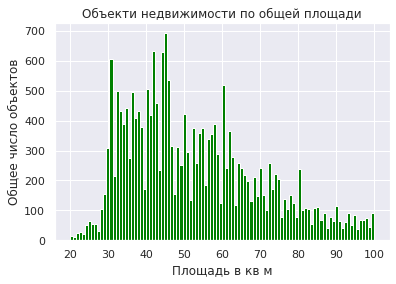

In [23]:
#Отсечем значения сильно выходящие за значения первого и четвертого квартиля
plt.hist(data['total_area'], bins=100, range=(20, 100), color = "green")
plt.title('Объекти недвижимости по общей площади')
plt.xlabel('Площадь в кв м')
plt.ylabel('Общее число объектов');

Данные выглядят вполне правдобподобно: большая часть квартир имеет площадь от 30 кв.м до 80 кв.м

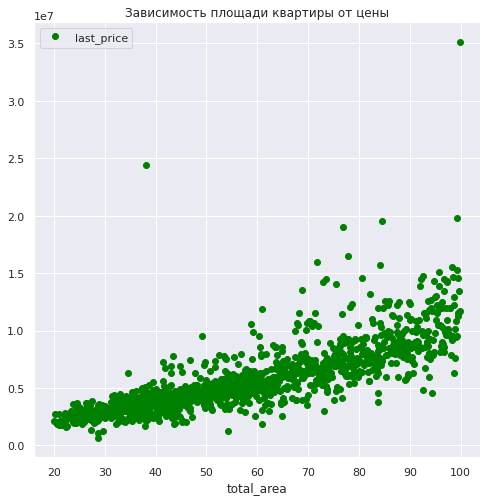

In [24]:
#Построим график на основе сводной таблицы, показывающей зависимость площади жилья и его цены. 
#Аномальные значения отсечем через query.
(
data.query('total_area > 20 and total_area < 100')
    .pivot_table(index= 'total_area', values = 'last_price', aggfunc = 'median')
    .plot(grid=True,  figsize=(8, 8), title='Зависимость площади квартиры от цены', color = "green", style='o')
);

In [25]:
#Посчитаем коэффициент корреляции между двумя значениями total_area и last_price
data['total_area'].corr(data['last_price'])

0.6536213939252808

Вывод: между значениями total_area и last_price прослеживается зависимость, значение коэффициента корреляции в 0.65 говорит нам о наличии умеренной зависимости между площадью недвижимости и ценой (чем больше площадь, тем больше цена).

### Жилая площадь.

In [26]:
data['living_area'].describe()

count    23565.000000
mean        34.102255
std         21.189133
min          2.000000
25%         19.000000
50%         30.000000
75%         41.100000
max        409.700000
Name: living_area, dtype: float64

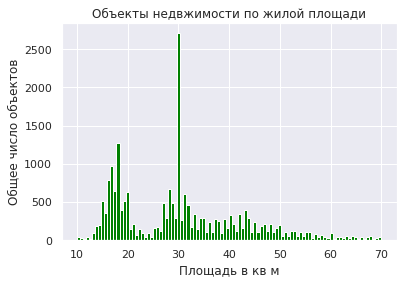

In [27]:
#Отсечем значения сильно выходящие за значения первого и четвертого квартиля 
plt.hist(data['living_area'], bins=100, range=(10, 70), color = "green")
plt.title('Объекты недвжимости по жилой площади')
plt.xlabel('Площадь в кв м')
plt.ylabel('Общее число объектов');

Во время предобработки данных мы заменили пустые значения на медианные,т.к. у нас стоит задача измерить влияние стоимости недвижимости на данный параметр, из-за этого на графике искажено количество квартир с жилой площадью в 30 кв.м.

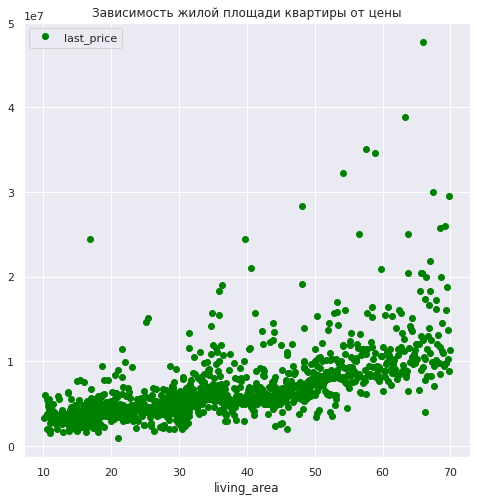

In [28]:
#Построим график на основе сводной таблицы, показывающей зависимость жилой площади и его цены. 
#Аномальные значения отсечем через query.
(
data.query('living_area > 10 and living_area < 70')
    .pivot_table(index= 'living_area', values = 'last_price', aggfunc = 'median')
    .plot(grid=True,  figsize=(8, 8), title='Зависимость жилой площади квартиры от цены', color = "green", style='o')
);

In [29]:
#Посчитаем коэффициент корреляции между двумя значениями living_area и last_price
data['living_area'].corr(data['last_price'])

0.5406077703823251

Вывод: между значениями living_area и last_price также прослеживается умеренная зависимость: чем больше жилая площадь, тем больше цена.

### Площадь кухни.

In [30]:
data['kitchen_area'].describe()

count    23565.000000
mean        10.423234
std          5.631746
min          1.300000
25%          7.300000
50%          9.100000
75%         11.410000
max        112.000000
Name: kitchen_area, dtype: float64

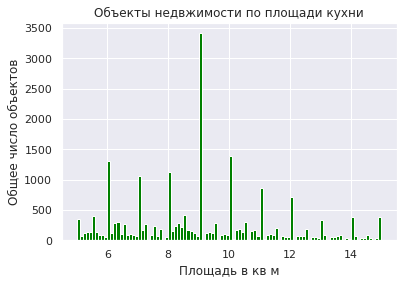

In [31]:
#Отсечем значения сильно выходящие за значения первого и четвертого квартиля 
plt.hist(data['kitchen_area'], bins=100, range=(5, 15), color = "green")
plt.title('Объекты недвжимости по площади кухни')
plt.xlabel('Площадь в кв м')
plt.ylabel('Общее число объектов');

Пик данных приходится на 9 кв.м, стандартный размер кухни в панельном жилье.

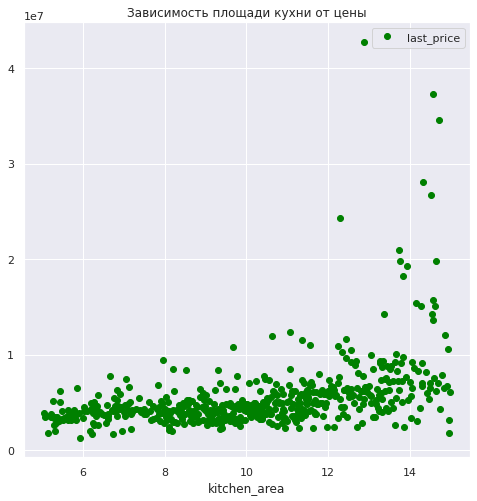

In [32]:
#Построим график на основе сводной таблицы, показывающей зависимость жилой площади и его цены. 
#Аномальные значения отсечем через query.
(
data.query('kitchen_area > 5 and kitchen_area < 15')
    .pivot_table(index= 'kitchen_area', values = 'last_price', aggfunc = 'median')
    .plot(grid=True,  figsize=(8, 8), title='Зависимость площади кухни от цены', color = "green", style='o')
);

In [33]:
#Посчитаем коэффициент корреляции между двумя значениями kitchen_area и last_price
data['kitchen_area'].corr(data['last_price'])

0.440695080376819

Между значениями kitchen_area и last_price также прослеживается определенная зависимость: но она слабее, чем зависимость от общей площади и жилой площади.

### Цена квартиры.

In [34]:
data['last_price'].describe()

count    2.356500e+04
mean     6.540058e+06
std      1.091093e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.646000e+06
75%      6.790000e+06
max      7.630000e+08
Name: last_price, dtype: float64

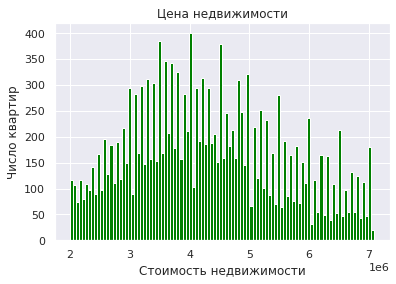

In [35]:
#Отсечем значения сильно выходящие за значения первого и четвертого квартиля
plt.hist(data['last_price'], bins=100, range=(2.000000e+06, 7.090000e+06), color = "green")
plt.title('Цена недвижимости')
plt.xlabel('Стоимость недвижимости')
plt.ylabel('Число квартир');

Вывод: большая часть квартир стоит от 3 до 6 млн руб. Выглядит правдоподобно для стоимости недвижимости в этом регионе в прошлом десятилетии.

### Количество комнат.

In [36]:
data['rooms'].describe()

count    23565.000000
mean         2.070656
std          1.078591
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

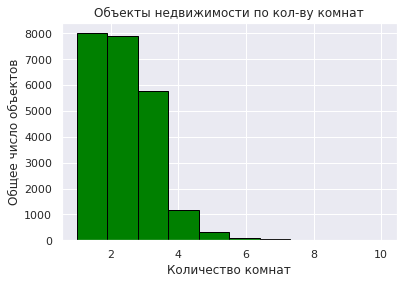

In [37]:
plt.hist(data['rooms'], bins=10, range=(1, 10), color = "green", ec='black')
plt.title('Объекты недвижимости по кол-ву комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Общее число объектов');

Большая часть квартир имеет 1,2 и 3 комнаты. Вопросов к данным нет.

<AxesSubplot:title={'center':'Зависимость кол-ва комнат от цены'}, xlabel='rooms'>

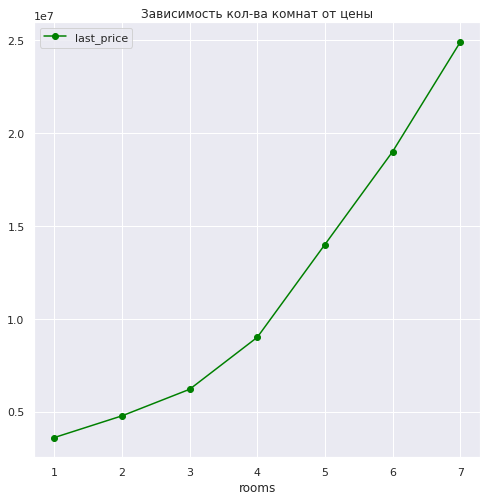

In [38]:
(
data.query('rooms >= 1 and rooms < 8')
    .pivot_table(index= 'rooms', values = 'last_price', aggfunc = 'median')
    .plot(grid=True,  figsize=(8, 8), title='Зависимость кол-ва комнат от цены', color = "green", style='-o')
)

In [39]:
#Посчитаем коэффициент корреляции между двумя значениями rooms и last_price
data['rooms'].corr(data['last_price'])

0.3631905485065752

Вывод: между rooms и last_price есть зависимость. При этом из графика видно, что с каждой дополнительной комнатой она становится сильнее.

### Высота потолков.

In [40]:
data['ceiling_height'].describe()

count    23565.000000
mean         2.698746
std          0.253630
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max         14.000000
Name: ceiling_height, dtype: float64

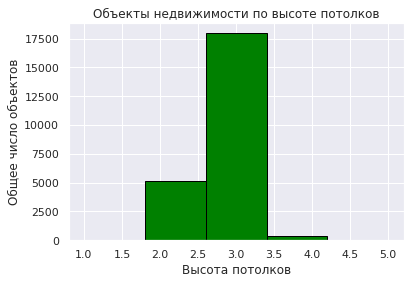

In [41]:
#Отсечем значения сильно выходящие за значения первого и четвертого квартиля 
plt.hist(data['ceiling_height'], bins=5, range=(1,5), color = "green", ec='black')
plt.title('Объекты недвижимости по высоте потолков')
plt.xlabel('Высота потолков')
plt.ylabel('Общее число объектов');

Вывод: размеры потоко варьируются от 1,8 м до 3,3 м, что тоже вполне стандартно.

### Категоризация по этажам.

In [42]:
data['category_by_floor'].describe()

count      23565
unique         3
top       другой
freq       17326
Name: category_by_floor, dtype: object

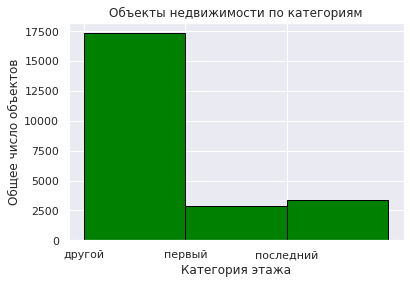

In [43]:
plt.hist(data['category_by_floor'], bins=3, range=(0, 3), color = "green", ec='black')
plt.title('Объекты недвижимости по категориям')
plt.xlabel('Категория этажа')
plt.ylabel('Общее число объектов');

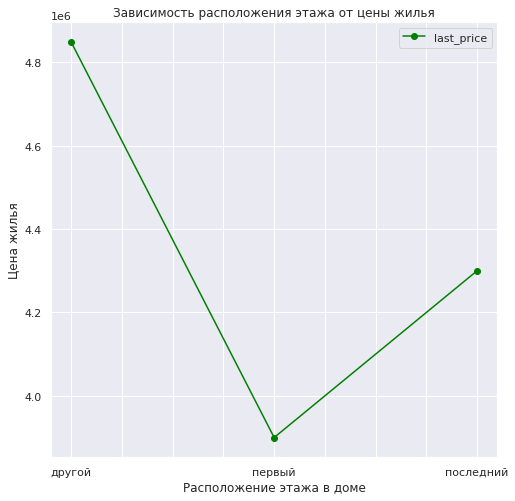

In [44]:
(
data.pivot_table(index='category_by_floor', values ='last_price', aggfunc = 'median')
    .plot(grid=True,  figsize=(8, 8), title='Зависимость расположения этажа от цены жилья', color = "green", style='-o')
)
plt.xlabel('Расположение этажа в доме')
plt.ylabel('Цена жилья')
plt.show()

Вывод: жилье на первом и последнем этаже гораздо дешевле, чем на любом другом.

### Общее количество этажей в доме.

In [45]:
data['floors_total'].describe()

count    23565.000000
mean        10.675875
std          6.594823
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

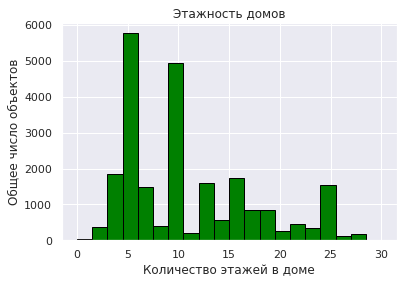

In [46]:
plt.hist(data['floors_total'], bins=20, range=(0, 30), color = "green", ec='black')
plt.title('Этажность домов')
plt.xlabel('Количество этажей в доме')
plt.ylabel('Общее число объектов');

Вывод: Большая часть квартир располагается в домах с пятью и девятью этажами.

### Расстояние от центра города.

In [47]:
data['city_center_distance'].describe()

count    18064.000000
mean        14.186504
std          8.621131
min          0.000000
25%          9.000000
50%         13.000000
75%         16.000000
max         66.000000
Name: city_center_distance, dtype: float64

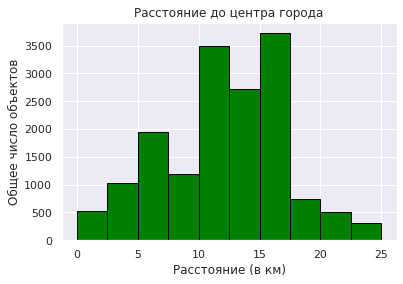

In [48]:
plt.hist(data['city_center_distance'], bins=10, range=(0, 25), color = "green", ec='black')
plt.title('Расстояние до центра города')
plt.xlabel('Расстояние (в км)')
plt.ylabel('Общее число объектов');

Вывод: у большинства объектов недвижимости, по которым у нас есть данные, расстояние до центра составляет от 10 до 17 км.

### Расстояние до ближайшего парка.

In [49]:
data['parks_nearest'].describe()

count    8030.000000
mean      490.580448
std       341.572956
min         1.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

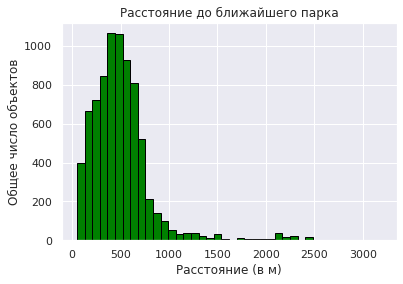

In [50]:
plt.hist(data['parks_nearest'], bins=40, range=(50, 3190), color = "green", ec='black')
plt.title('Расстояние до ближайшего парка')
plt.xlabel('Расстояние (в м)')
plt.ylabel('Общее число объектов');

Вывод: у большинства объектов недвижимости, по которым у нас есть данные, расстояние до ближайшего парка составляет от 200 до 900 м.

<div class="alert alert-success">
<b>✔️ Комментарий ревьюера v1:</b> 
<br>Ты корректно подбираешь основные диапазоны, а также верно читаешь графики! 
</div>

### Зависимость цены квартиры от даты размещения (день недели, месяц, год).

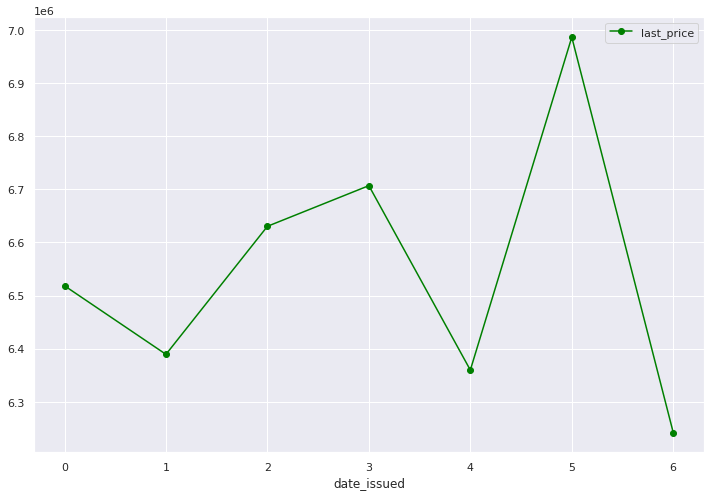

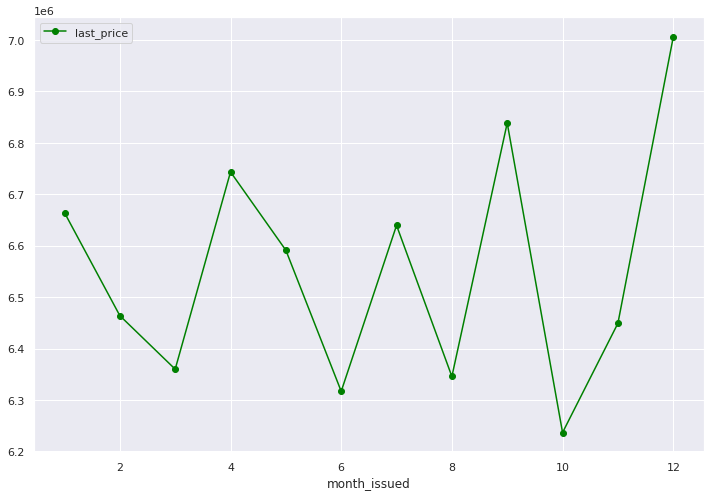

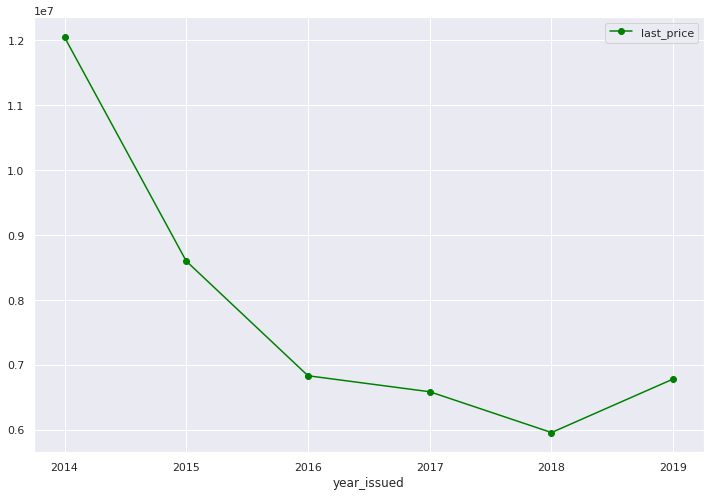

In [51]:
#Зависимость от дня
(
data.pivot_table(index='date_issued', values='last_price')
    .plot(grid=True, figsize=(12, 8), color = "green", style='o-')
)
plt.show()
#Зависимость от месяца
(
data.pivot_table(index='month_issued', values='last_price')
    .plot(grid=True, figsize=(12, 8), color = "green", style='o-')
)
plt.show()
#Зависимость от года
(
data.pivot_table(index='year_issued', values='last_price')
    .plot(grid=True, figsize=(12, 8), color = "green", style='o-')
)
plt.show()

Вывод: на вышеприведенных графиках видно, что:
- В субботу и четверг опубликованы наиболее дорогие квартиры
- В сентябре, апреле и декабре опубликованы объявления с наиболее дорогими объектами
- Цены на квартиры снижались в 2015-2017 г, с 2018 начали расти

### Задание «Изучите, как быстро продавались квартиры (столбец days_exposition)

In [52]:
#Посмотрим данные в столбце days_exposition
data['days_exposition'].describe()

count    20394.000000
mean       180.741395
std        219.732782
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

Из данных выше видно, что количество дней между вторым и третьим квартилем варьируется от 45 до 95. При этом до 75% объектов были проданы в течение 231 дня. Составим график, установим значения от 30 до 300 дней и посмотрим на их распределение.

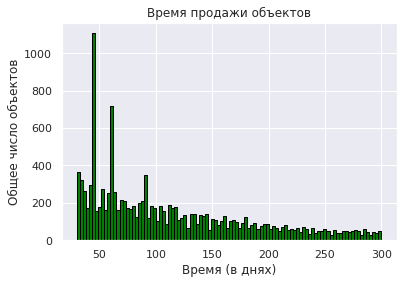

In [53]:
# Строим гистограмму
plt.hist(data['days_exposition'], bins=100, range=(30, 300), color = "green", ec='black')
plt.title('Время продажи объектов')
plt.xlabel('Время (в днях)')
plt.ylabel('Общее число объектов');

Вывод: наибольшее количество продаж приходится на период 40-60 дней. Быстрыми можно назвать продажи, состоявшиеся после 40-45 дней после размещения объявления, долгими - больше 231 дня после размещения объявления.

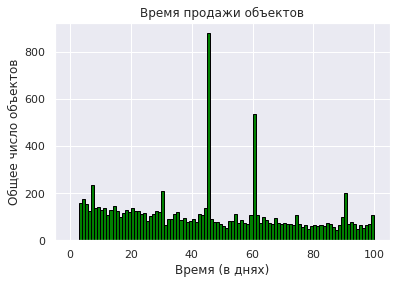

In [54]:
# Строим гистограмму
plt.hist(data['days_exposition'], bins=100, range=(0, 100), color = "green", ec='black')
plt.title('Время продажи объектов')
plt.xlabel('Время (в днях)')
plt.ylabel('Общее число объектов');

<div class="alert alert-info">
<b>Комментарий студента:</b>
<br> Скорее всего объявление просто убиралось автоматически через 45 дней после публикации 🙂
</div>

### Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений

In [55]:
#Отсортируем данные в столбце locality_name по 10 пунктам с наибольшим числом объявлений
data['locality_name'].value_counts().head(10)

Санкт-Петербург    15651
Мурино               586
Кудрово              470
Шушары               439
Всеволожск           398
Пушкин               369
Колпино              338
Парголово            327
Гатчина              307
Выборг               237
Name: locality_name, dtype: int64

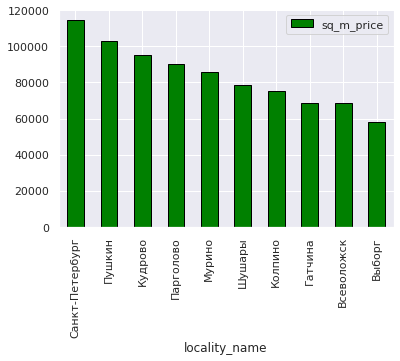

In [56]:
#Методом query обратимся к самым популярным населенным пунктам выше, создадим сводную таблицу и отсортируем данные по убыванию
(
data.query('locality_name == ["Санкт-Петербург","Мурино","Кудрово","Шушары","Всеволожск","Пушкин","Колпино","Парголово","Гатчина","Выборг"]')
    .pivot_table(index='locality_name', values='sq_m_price')
    .sort_values(by='sq_m_price', ascending = False)
    .plot(kind='bar', legend=True, grid=True,color = "green", ec='black')
);

Вывод: наибольшая цена одного квадратного метра в г. Санкт-Петербург, в аутсайдерах - Гатчина, Всеволожск	и Выборг.

#### Выделите квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислите их среднюю стоимость на разном удалении от центра

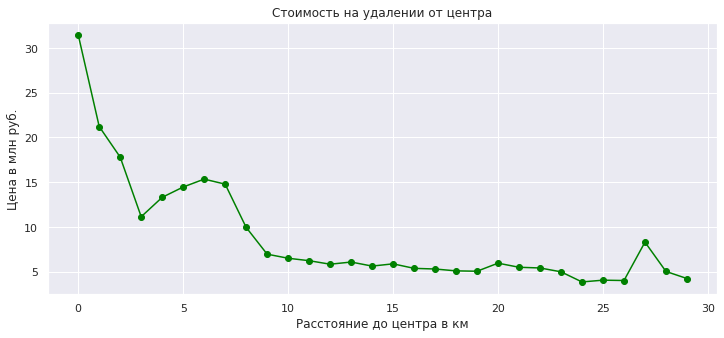

In [57]:
#Переведем данные в столбце last_price в млн руб.
data['last_price'] = data['last_price'] / 1000000
#Методом query 
(
data.query('locality_name == "Санкт-Петербург"')
    .pivot_table(index='city_center_distance', values='last_price')
    .plot(grid=True, figsize=(12, 5), color = "green", style='o-', legend=False)
)
plt.title('Стоимость на удалении от центра')
plt.xlabel('Расстояние до центра в км')
plt.ylabel('Цена в млн руб.');

Вывод: удаление от центра города более, чем на 9 км уже не сильно влияет на цену недвижимости. Выброс в конце графика может говорить о жилье бизнес-класса и выше вне городской черты.

## Общий вывод.

В ходе исследования была проведена предобработка данных, добавлены новые параметры, исследованы параметры, характеризующие объекты недвижимости их влияние на ее стоимость.
- Наибольшее влияние на цену объекта оказывает площадь недвижимости
- Расстояние до центра города оказывает влияние на цену в радиусе 9 км
- Квартиры в Санкт-Петербурге имеют гораздо большую цену кв. м., чем в окрестностях города
- Срок продажи для большей части квартир не превышает 95 дней (~3 месяца)
- Большая часть объектов представляют собой однокомнатные, двухкомнатные и трехкомнатные квартиры. Число комнат также влияет на конечную стоимость жилья.
- Объекты, находящиеся на первом и последнем этаже продаются с дисконтом
- Большая часть объектов являются квартирами в пятиэтажных и девятиэтажных домах.